<a href="https://colab.research.google.com/github/xEvheMary/MI-BCI-UnityKart/blob/main/ColabScripts/Classification_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
%matplotlib inline

In [ ]:
!pip install mne &> /dev/null
!pip install mne-icalabel &> /dev/null
!pip install skorch -U &> /dev/null

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
import math
from scipy.io import loadmat
import pickle
import gc

In [ ]:
from mne.preprocessing import ICA
from mne_icalabel import label_components
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import ShuffleSplit, cross_val_score, GridSearchCV, GroupKFold
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from mne.decoding import CSP
from skorch import NeuralNetClassifier

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import signal
from skorch.callbacks import Checkpoint, EpochScoring, EarlyStopping

In [ ]:
mne.set_log_level('WARNING')

# Subject

In [ ]:
sbj_n = 2 #@param {type:"integer"}
sbj_path = 'Subject ' + str(sbj_n)

# Dataset

In [ ]:
base_path = '/content/drive/MyDrive/Th/EEG Recording'
subj_folder = os.path.join(base_path, sbj_path)
l = [file for file in os.listdir(subj_folder) if file.endswith('gdf')]

In [ ]:
type_1 = [file for file in os.listdir(subj_folder) if file.endswith('1.gdf')]
type_2 = [file for file in os.listdir(subj_folder) if file.endswith('2.gdf')]
smaller = min(len(type_1), len(type_2))
type_1 = type_1[:smaller]
type_2 = type_2[:smaller]

# Constants

In [ ]:
# Constants
ch_list = ['Fp1', 'Fp2', 'AF3', 'AF4', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz','FC4', 'FT8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']
# For epoching
st = 0
# For sub-epochs
sub_dur = 2
stride = 0.25
# For cross-validation dataset
n_splits = 4
chn9 = ['FC3', 'FCz', 'FC4', 'C3', 'Cz', 'C4', 'CP3', 'CPz', 'CP4']
chn13 = ['Fz','FC3','FCz','FC4','T7','C3','Cz','C4','T8','CP3','CPz','CP4','Pz',] # Diamond shaped (1,3,5,3,1)
chn15 = ['F3', 'Fz', 'F4','FC3', 'FCz', 'FC4', 'C3', 'Cz', 'C4', 'CP3', 'CPz', 'CP4','P3', 'Pz', 'P4']

### Classifier parameters

In [ ]:
chn_select = chn9 #@param ['chn9', 'chn13','chn15'] {type:"raw"}
bp_range = (7,30)
csp_comp = 4
sample_rate = None #@param ['128', 'None'] {type:"raw"}
cls_n = 3
learn_rate = 0.0001

# Functions

### Sub-Functions

In [ ]:
def load_ds(pt, f):       # For BCIC Dataset
  fp = os.path.join(pt, f)
  print("File path: {}".format(fp))
  if fp.endswith('gdf'):
    raw_data = mne.io.read_raw_gdf(fp, preload=True)
  else:
    raw_data = None
  return raw_data

def select_event(events_from_annot, event_dict, sfreq):
  # specify needed event
  l_ev = event_dict['769']
  r_ev = event_dict['770']
  x_ev = event_dict['33024']
  end_trial = event_dict['800']
  needed_event = [l_ev, r_ev, x_ev, end_trial]
  # Remove unecessary last part
  re = events_from_annot[::-1, 2].tolist()  # reverse
  last_id = re.index(end_trial)             # Find index of last end signal
  if last_id > 0:                           # Filter out last part
    events_annot = events_from_annot[:-last_id]
  else:
    events_annot = events_from_annot[:]
  # Filter other event except the one used
  mask = np.isin(events_annot[:, 2], needed_event)
  filtered_events = events_annot[mask]
  # Get durations
  a = np.diff(filtered_events[:, 0])/sfreq
  dur = round(np.mean(a[::2]),2)
  print('Average duration of this session trials : ',dur)
  return needed_event, dur

In [ ]:
def plot_multi(data, info, col, row, title='Plot'):
  # Data has to be array
  fig, axes = plt.subplots(row, col, figsize=(15, 8))
  for ep_id, ax in enumerate(axes.flat[:]):
    mne.viz.plot_topomap(data[ep_id], info, axes=ax, show=False)
    ax.set_title(f'Epoch {ep_id + 1}')
  fig.suptitle(title)
  fig.subplots_adjust(bottom=0.1, right=0.87, top=0.9)
  cax = plt.axes((0.9, 0.13, 0.02, 0.76))
  fig.colorbar(axes.flat[-1].images[-1], cax=cax).ax.set_yscale("linear")

### Data Functions

In [ ]:
# Load data. Apply ICA and apply bandpass.
def load_set(type_dd, use_ica=True, pick=None):
  all_set = []
  for data in type_dd:
    # Handle the raw
    x = load_ds(subj_folder, data)
    channel_mapping = {old_name: new_name for old_name, new_name in zip(x.ch_names, ch_list)}   # Remap channels
    x.rename_channels(channel_mapping)
    montage = mne.channels.make_standard_montage('standard_1020')
    _ = x.set_montage(montage)
    # Channel Select
    if pick:
      x.pick_channels(pick, ordered=True)
    all_set.append(x)
    # Prep
    x.filter(l_freq=2, h_freq=40)       # Filter
    x = x.set_eeg_reference("average")  # Average Reference
    if use_ica:
      x = custom_ica.transform(x)
  return all_set

In [ ]:
# Load data only. Pick channel is optional. Concatenate all raw into one raw.
def load_ica_set(file_list: list, pick=None):
  combined_set = []
  for data in file_list:
    x = load_ds(subj_folder, data)    # Load data
    combined_set.append(x)
  raw_cat = mne.concatenate_raws(combined_set)
  channel_mapping = {old_name: new_name for old_name, new_name in zip(raw_cat.ch_names, ch_list)}   # Remap channels
  raw_cat.rename_channels(channel_mapping)
  montage = mne.channels.make_standard_montage('standard_1020')
  _ = raw_cat.set_montage(montage)
  if pick:
    raw_cat.pick_channels(pick, ordered=True)
  return raw_cat

In [ ]:
def calculate_mav(x, base=None, picks=['C3','Cz','C4']):
  mav = np.abs(x.pick_channels(picks).get_data(copy=True)).mean(axis=2)
  if base:
    base_mav = np.abs(base.pick_channels(picks).get_data(copy=True)).mean(axis=2)
    base_mav_mean = base_mav.mean(axis=0)
    mav = mav - base_mav_mean
  return mav

In [ ]:
def compute_alpha(epoch, bandpass=(8, 13),picks=['C3','Cz','C4']):
  alpha_band = bandpass
  if picks:
    picked = picks
  else:
    picked = epoch.ch_names
  # Compute PSD
  spectrum = epoch.compute_psd(picks=picked)
  frequencies = spectrum.freqs
  # Find indices corresponding to alpha band frequencies
  alpha_indices = np.logical_and(frequencies >= alpha_band[0], frequencies <= alpha_band[1])
  # Extract PSD values in the alpha band
  alpha_psd_epochs = spectrum.data[:, :, alpha_indices]
  alpha_psds = alpha_psd_epochs.mean(axis=-1)
  return alpha_psds

In [ ]:
def make_dataset(ep_list, lbl_list, balance=False, filter=None, pick=None, sample_rate=None):
  ep_len = [len(x) for x in ep_list]
  if balance:
    for i, ep in enumerate(ep_list):
      if len(ep) > min(ep_len):
        random_indices = np.random.choice(len(ep), size=min(ep_len), replace=False)
        ep_list[i] = ep[random_indices]
        ep_len = [len(x) for x in ep_list]
  if filter != None :
    ep_list = [x.filter(l_freq=filter[0], h_freq=filter[1]) for x in ep_list]
  if sample_rate != None :
    ep_list = [x.resample(sample_rate, npad='auto') for x in ep_list]
  data_list = [x.get_data(picks=pick, copy=True) for x in ep_list]
  infos = x.copy().pick(pick).info
  lbls_list = [[d]*ep_len[i] for i, d in enumerate(lbl_list)]
  data = np.concatenate(data_list)
  lbls = np.concatenate(lbls_list)
  return data, lbls, infos

In [ ]:
def make_sub_dataset(ep_list, lbl_list, balance=False, filter=None, pick=None, sample_rate=None, sub_dur=2, stride=0.25):
  data_list = []
  lbls_list = []
  ep_len = [len(x) for x in ep_list]
  if balance:
    for i, ep in enumerate(ep_list):
      if len(ep) > min(ep_len):
        random_indices = np.random.choice(len(ep), size=min(ep_len), replace=False)
        ep_list[i] = ep[random_indices]
        ep_len = [len(x) for x in ep_list]
  for ev, x in enumerate(ep_list):
    if filter != None :
      x = x.copy().filter(l_freq=filter[0], h_freq=filter[1])
    if sample_rate != None :
      x = x.copy().resample(sample_rate, npad='auto')
    data_array = x.get_data(picks=pick, copy=True)
    sfq = x.info['sfreq']
    samples_per_epoch = int(sub_dur * sfq)
    samples_per_stride = int(stride * sfq)
    sub_data = []
    for i in range(0, data_array.shape[0]):
      for start in range(0, data_array.shape[-1] - samples_per_epoch + 1, samples_per_stride):
        sub_epoch_data = data_array[i, :, start:start + samples_per_epoch]
        sub_data.append(sub_epoch_data)
    sub_epoch = np.array(sub_data)
    epoch_lbl = [lbl_list[ev]]*sub_epoch.shape[0]
    data_list.append(sub_epoch)
    lbls_list.append(epoch_lbl)
  infos = x.copy().pick(pick).info
  data = np.concatenate(data_list)
  lbls = np.concatenate(lbls_list)
  return data, lbls, infos

## Visualization Functions

In [ ]:
def lap_feat_plot(feat, title='Plot', ev_line=[], picks=['C3','Cz','C4']):
  colors = plt.cm.hsv(np.linspace(0, 0.5, feat.shape[1]))
  text_line = [x for x in range(0, feat.shape[0], round(feat.shape[0]/4))]
  if len(ev_line)<1 :
    lap_line = text_line # Add lines that split the lap into 4 sections
  else:
    lap_line = ev_line
  text_positions = [(text_line[i] + text_line[i+1]) / 2 for i in range(len(text_line)-1)]
  text_labels = ['Straight', 'Left', 'Straight', 'Right']
  line_min = np.amin((feat))
  line_max = np.amax((feat))
  # Plot
  plt.figure(figsize=(12, 4))
  for i in range(feat.shape[1]):
    plt.plot(feat[:, i], color=colors[i])
  for pos, label in zip(text_positions, text_labels):
    plt.text(pos, line_max, label, fontsize=10, ha='center', va='center', color='blue')
  plt.xlabel('Time')
  plt.title(title)
  plt.vlines(x = lap_line, ymin = line_min, ymax = line_max, colors = 'lightblue')
  plt.legend(picks)
  plt.show()

In [ ]:
def predict_pos_transform(array):
    sorted_indices = np.argsort(array, axis=1)
    max_indices = sorted_indices[:, -1]
    second_max_indices = sorted_indices[:, -2]

    # Initialize an array to store the transformed values
    transformed_values = np.empty(array.shape[0], dtype=array.dtype)

    for i in range(array.shape[0]):
        max_idx = max_indices[i]
        second_max_idx = second_max_indices[i]
        max_value = array[i, max_idx]

        if max_idx == 0:    # Straight
            if second_max_idx == 1:
                transformed_values[i] = 0.5 - (max_value/2)
            elif second_max_idx == 2:
                transformed_values[i] = -0.5 + (max_value/2)
        elif max_idx == 1:  # Left
            transformed_values[i] = max_value + 0.5
        elif max_idx == 2:  # Right
            transformed_values[i] = -0.5 - max_value

    return transformed_values

def plot_predict(trial, sub_trial, cls, plt_type='event', ev_line=[], fig_size=(8,10), title=''):
  if plt_type == 'event':
    trial_pos = predict_pos_transform(trial)
    sub_trial_pos = predict_pos_transform(sub_trial)
    ev_len = len(sub_trial_pos)/len(trial_pos)
    fig, axes = plt.subplots(len(cls), 1, figsize=fig_size)
    for id, ax in enumerate(axes.flat[:]):
      dt = sub_trial_pos[id*int(ev_len):(id+1)*int(ev_len)]
      trial_line = ax.axhline(y=trial_pos[id], xmin=0, xmax=len(dt), color='red', label='Trained with trial_window')
      moving_line, = ax.plot(dt, label='Trained with moving_window')
      right_span = ax.axhspan(-1.5, -0.5, alpha=0.25, color='red', ec=None, label='Right')   # Right
      straight_span = ax.axhspan(-0.5, 0.5, alpha=0.25, color='green', ec=None, label='Straight')  # Straight
      left_span = ax.axhspan(0.5, 1.5, alpha=0.25, color='blue', ec=None, label='Left')    # Left
      ax.legend(handles=[left_span, straight_span, right_span], loc='center left', bbox_to_anchor=(0.9, 0.5))
      ax.set_title(cls[id])
    fig.legend(handles=[trial_line, moving_line], loc='outside lower center', ncol=2)
    fig.suptitle(title)
  elif plt_type == 'lap':
    trial_pos = predict_pos_transform(trial)
    sub_trial_pos = predict_pos_transform(sub_trial)
    if len(trial_pos) < len(sub_trial_pos):
      scale = int(len(sub_trial_pos)/len(trial_pos))
      trial_pos = np.repeat(trial_pos, scale)
    fig = plt.figure(figsize=fig_size)
    if len(ev_line) > 0:
      plt.vlines(x = ev_line, ymin = -1.5, ymax = 1.5, colors = 'black', label='_nolegend_')
    text_list = ['straight', 'left', 'straight', 'right']
    text_index = 0  # Index for the text_list
    # Iterate through the x values and check the distance between consecutive values
    for i in range(len(ev_line) - 1):
      distance = ev_line[i + 1] - ev_line[i]
      if distance > 20:
        # Calculate the midpoint between the two lines
        midpoint = (ev_line[i] + ev_line[i + 1]) / 2
        # Plot the text at the midpoint
        plt.text(midpoint, 0.975, text_list[text_index], fontsize=14, horizontalalignment='center', verticalalignment='center',
                  transform=plt.gca().get_xaxis_transform())
        text_index += 1
    right_span = plt.axhspan(-1.5, -0.5, alpha=0.25, color='red', ec=None, label='Right')   # Right
    straight_span = plt.axhspan(-0.5, 0.5, alpha=0.25, color='green', ec=None, label='Straight')  # Straight
    left_span = plt.axhspan(0.5, 1.5, alpha=0.25, color='blue', ec=None, label='Left')    # Left
    trial_line, = plt.plot(trial_pos, label='Trial window trained classifier')
    moving_line, = plt.plot(sub_trial_pos, label='Moving window trained classifier')
    fig.legend(handles=[trial_line, moving_line], loc='upper center', bbox_to_anchor=(0.5, 0.07),
          fancybox=True, ncol=2)
    fig.legend(handles=[left_span, straight_span, right_span], loc='center left', bbox_to_anchor=(0.9, 0.5))
    plt.title(title)
  else:
    print('Wrong type')
  return

# Object

### ICA Object

In [ ]:
class CustomICA(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=20, components_to_remove=None, ica_params=None):
        self.n_components = n_components
        self.components_to_remove = components_to_remove
        self.ica_params = ica_params
        self.ica = ICA(**ica_params) if ica_params else ICA(n_components=n_components, max_iter="auto", method="infomax", fit_params=dict(extended=True))

    def fit(self, X, y=None):
        X.load_data()
        X.filter(l_freq=1, h_freq=100)
        X = X.set_eeg_reference("average")
        self.ica.fit(X)
        ic_labels = label_components(x, self.ica, method="iclabel")
        labels = ic_labels["labels"]
        exclude_idx = [idx for idx, label in enumerate(labels) if label not in ["brain", "other"]]
        self.ica.exclude = exclude_idx
        return self

    def transform(self, X):
        return self.ica.apply(X)

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

    def save(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as file:
            return pickle.load(file)

### Subject Raw Object

In [ ]:
class SubjectEpochs():
  def __init__(self, raw_list, ica=None):
    self.raw_list = raw_list
    self.baseline = []
    self.imagery = []
    self.needed_event = None
    self.event_duration = []
    self.ica = ica

  def default_load(self):
    # Used for public dataset. Apply ICA before putting the raw into object, this function doesn't automatically do that.
    for x in self.raw_list:
      self.imagery.append(x)
    print('Loaded raw into object. Do event_epoch(). Not recommended to do moving_epoch().')
    return

  def base_img_split(self):
    # Used for custom dataset.
    for x in self.raw_list:
      events_from_annot, event_dict = mne.events_from_annotations(x)
      base_end =  np.floor(events_from_annot[0,0]/x.info['sfreq'])
      needed_event, dur = select_event(events_from_annot, event_dict, x.info['sfreq'])
      baseline_raw = x.copy().crop(tmax=base_end)
      imagery_raw = x.copy().crop(tmin=base_end)
      self.baseline.append(baseline_raw)
      self.imagery.append(imagery_raw)
      self.event_duration.append(dur)
    self.needed_event = needed_event
    return

  def moving_epoch(self, x):
    if len(x) > 0:
      res, combined = self.create_sub_epoch(x)
      return res, combined
    else:
      print('Data List empty. Do base_img_split() for custome set and default_load() for public set.')

  def event_epoch(self, event: str, raw=None, tmin=-0.5, tmax=4):
    if raw == None:
      raws = self.imagery
    else:
      raws = raw
    # Split by event
    event_list = []
    for x in raws:
      # Get events
      events_from_annot, event_dict = mne.events_from_annotations(x)
      # Events IDs
      if event == 'left':
        ev_id = event_dict['769']
      elif event == 'right':
        ev_id = event_dict['770']
      elif event == 'straight':
        ev_id = event_dict['33024']   # Probably doesn't exist in public set
      else:
        print('Unspecified event. Choose between [\'left\',\'right\',\'straight\']')
        return
      epoch_res = mne.Epochs(x, events_from_annot, event_id=ev_id, tmin=tmin, tmax=tmax, preload=True)
      event_list.append(epoch_res)
    event_epochs = mne.concatenate_epochs(event_list)
    return event_epochs

  def create_sub_epoch(self, x_list):
    res = [self.segment_epoch(x) for x in x_list]
    epochs_array = mne.concatenate_epochs(res)
    return res, epochs_array

  def create_sub_event(self, epoch):
    return

  def segment_laps(self):
    # Only to be used for custom recorded dataset
    laps = []
    for x in self.raw_list:
      events_from_annot, event_dict = mne.events_from_annotations(x)
      needed_event, dur = select_event(events_from_annot, event_dict, x.info['sfreq'])
      filtered_events = [event for event in events_from_annot if event[2] in needed_event]
      pairs = [(i, i+7) for i in range(0, len(filtered_events) - 7, 8)]
      for start_index, end_index in pairs:
        # Set tmin and tmax based on the indices
        start_ev = filtered_events[start_index][0]
        end_ev = filtered_events[end_index][0]
        tmin = x.times[start_ev]
        tmax = x.times[end_ev]
        raw_crop = x.copy().crop(tmin=tmin, tmax=tmax)
        laps.append(raw_crop)
    lap_list = []
    ends = [raw.times[-1] for raw in laps]
    for raw in laps:
      events, _ = mne.events_from_annotations(raw)  # Extract events from the raw data
      epochs = mne.Epochs(raw, events=events, tmin=0, tmax=min(ends), baseline=None, detrend=1, preload=True)
      lap_list.append(epochs)
    lap_eps = mne.concatenate_epochs(lap_list)
    return laps, lap_eps

  def segment_epoch(self, raw, sub_dur=2, stride=0.25):
    sfq = raw.info['sfreq']
    raw_data = raw.get_data()
    samples_epoch = int(sub_dur * sfq)
    samples_stride = int(stride * sfq)
    num_channels, num_samples = raw_data.shape
    epochs_data = []
    for start in range(0, num_samples - samples_epoch + 1, samples_stride):
        epoch_data = raw_data[:, start:start + samples_epoch]
        epochs_data.append(epoch_data)
    epochs_array = np.array(epochs_data)
    epochs = mne.EpochsArray(epochs_array, raw.info, tmin=0, verbose=True)
    return epochs

### EEGNet

In [ ]:
# https://github.com/High-East/BCI-ToolBox/blob/master/models/EEGNet/EEGNet.py
class EEGNet(nn.Module):
    def __init__(self, in_chn, n_cls, input_ts, f1=8, f2=16, d=2, drop_prob=0.5):
        super(EEGNet, self).__init__()

        self.F1 = f1   # High Frequency pattern
        self.F2 = f2   # Lower Frequency patter
        self.D = d    # Dilation (?), spatial?
        #
        self.kernel_l = math.ceil(128/2)
        self.chn = in_chn
        self.cls = n_cls
        self.drop_prob = drop_prob
        self.tp = input_ts

        # Spectral
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, self.kernel_l), padding=(0, math.ceil(self.kernel_l//2)), bias=False),
            nn.BatchNorm2d(self.F1)
        )

        # Spectral-specific Spatial
        self.conv2 = nn.Sequential(
            nn.Conv2d(self.F1, self.D*self.F1, (self.chn, 1), groups=self.F1, bias=False),
            nn.BatchNorm2d(self.D*self.F1),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(self.drop_prob)
        )

        # Temporal
        self.conv3 = nn.Sequential(
            nn.Conv2d(self.D*self.F1, self.D*self.F1, (1, math.ceil(self.kernel_l//4)), padding=(0, 8), groups=self.D*self.F1, bias=False),
            nn.Conv2d(self.D*self.F1, self.F2, (1, 1), bias=False),
            nn.BatchNorm2d(self.F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(self.drop_prob)
        )

        #self.classifier = nn.Linear(math.ceil(self.kernel_l/4)* math.ceil(self.tp//32), self.cls, bias=True)
        self.classifier = nn.Linear(self.F2 * math.ceil(self.tp//32), self.cls, bias=True)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, self.F2*math.ceil(self.tp//32))
        x = self.classifier(x)
        #x = self.softmax(x)
        return x

# Preprocess

## ICA

In [ ]:
# Load dataset, combined into one raw
x = load_ica_set([type_1[0]] + [type_2[0]] + [type_1[-1]] + [type_2[-1]], pick=None)

File path: /content/drive/MyDrive/Th/EEG Recording/Subject 2/record-[2024.01.31]_S2_1.gdf
File path: /content/drive/MyDrive/Th/EEG Recording/Subject 2/record-[2024.01.31]_S1_2.gdf
File path: /content/drive/MyDrive/Th/EEG Recording/Subject 2/record-[2024.01.31]_S8_1.gdf
File path: /content/drive/MyDrive/Th/EEG Recording/Subject 2/record-[2024.01.31]_S7_2.gdf


In [ ]:
# ICA Object
comp_count = min(20, len(x.ch_names))
custom_ica = CustomICA(n_components=comp_count)

In [ ]:
custom_ica.fit(x)

CustomICA()

## Type 1 Data

In [ ]:
type_dd = type_1 # @param ["type_1", "type_2"] {type:"raw"}
print(type_dd)

['record-[2024.01.31]_S2_1.gdf', 'record-[2024.01.31]_S4_1.gdf', 'record-[2024.01.31]_S6_1.gdf', 'record-[2024.01.31]_S8_1.gdf']


In [ ]:
all_raw = load_set(type_dd)

File path: /content/drive/MyDrive/Th/EEG Recording/Subject 2/record-[2024.01.31]_S2_1.gdf
File path: /content/drive/MyDrive/Th/EEG Recording/Subject 2/record-[2024.01.31]_S4_1.gdf
File path: /content/drive/MyDrive/Th/EEG Recording/Subject 2/record-[2024.01.31]_S6_1.gdf
File path: /content/drive/MyDrive/Th/EEG Recording/Subject 2/record-[2024.01.31]_S8_1.gdf


In [ ]:
sbj = SubjectEpochs(all_raw)
sbj.base_img_split()

Average duration of this session trials :  6.21
Average duration of this session trials :  6.21
Average duration of this session trials :  6.21
Average duration of this session trials :  6.21


In [ ]:
base_list ,base_epochs = sbj.create_sub_epoch(sbj.baseline)

Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated


### Base MAV

In [ ]:
base_mav = np.abs(base_epochs.get_data(copy=True)).mean(axis=2)

## Laps

In [ ]:
sbj_laps, sbj_lap_epochs = sbj.segment_laps()

Average duration of this session trials :  6.21
Average duration of this session trials :  6.21
Average duration of this session trials :  6.21
Average duration of this session trials :  6.21


<ipython-input-25-991b971acef8>:93: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  lap_eps = mne.concatenate_epochs(lap_list)


In [ ]:
sbj_sub_lap_list, sbj_sub_laps = sbj.moving_epoch(sbj_laps)

Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
98 matching events found


In [ ]:
evs, ev_dict = mne.events_from_annotations(sbj_laps[0])

## Event

In [ ]:
left = sbj.event_epoch('left', tmax=6)
right = sbj.event_epoch('right', tmax=6)
straight = sbj.event_epoch('straight', tmax=6)

<ipython-input-25-991b971acef8>:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  event_epochs = mne.concatenate_epochs(event_list)
<ipython-input-25-991b971acef8>:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  event_epochs = mne.concatenate_epochs(event_list)
<ipython-input-25-991b971acef8>:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  event_epochs = mne.concatenate_epochs(event_list)


### Train

#### Dataset

In [ ]:
train_data, train_lbls, train_info = make_dataset([straight, left, right], [0,1,2], balance=True, filter=bp_range, pick=chn_select, sample_rate=sample_rate)

In [ ]:
train_data2, train_lbls2, train_info2 = make_sub_dataset([straight, left, right], [0,1,2], balance=True, filter=bp_range, pick=chn_select, sample_rate=sample_rate)

In [ ]:
groups = np.concatenate([[i] * int((train_data.shape[0]/3)/len(type_dd)) for i in range(0, len(type_dd))]*3)
groups2 = np.concatenate([[i] * int((train_data2.shape[0]/3)/len(type_dd)) for i in range(0, len(type_dd))]*3)

#### Classifier

In [ ]:
lda = LinearDiscriminantAnalysis()
svc = SVC(kernel='linear', gamma='auto', probability=True)
csp = CSP(n_components=csp_comp, reg=None, log=False, norm_trace=False)
#scaler = Scaler(scalings='mean')

clf_lda = Pipeline([("CSP", csp), ("LDA", lda)])
clf_svm = Pipeline([("CSP", csp), ("SVC", svc)])

In [ ]:
cv = GroupKFold(n_splits=len(type_dd))

In [ ]:
scores_lda = cross_val_score(clf_lda, train_data, train_lbls, cv=cv, groups=groups, n_jobs=None)

In [ ]:
scores_svc = cross_val_score(clf_svm, train_data, train_lbls, cv=cv, groups=groups, n_jobs=None)

In [ ]:
# Printing the results
class_balance = np.mean(train_lbls == train_lbls[0])
class_balance = max(class_balance, 1.0 - class_balance)
print("LDA Classification accuracy: %f / Chance level: %f" % (np.mean(scores_lda), class_balance))
print(scores_lda)
print("SVM Classification accuracy: %f / Chance level: %f" % (np.mean(scores_svc), class_balance))
print(scores_svc)

LDA Classification accuracy: 0.541667 / Chance level: 0.666667
[0.66666667 0.41666667 0.58333333 0.5       ]
SVM Classification accuracy: 0.656250 / Chance level: 0.666667
[0.66666667 0.75       0.58333333 0.625     ]


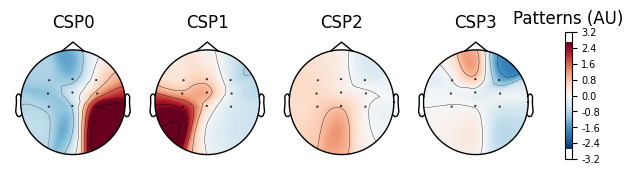

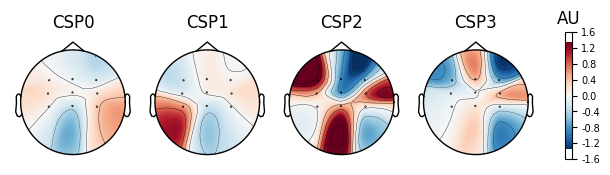

In [ ]:
csp.fit_transform(train_data, train_lbls)

_ = csp.plot_patterns(train_info, ch_type="eeg", units="Patterns (AU)")
_ = csp.plot_filters(train_info, scalings=1e-6)

In [ ]:
for train_index, test_index in cv.split(train_data, train_lbls, groups):
    break

In [ ]:
clf_lda.fit(train_data[train_index], train_lbls[train_index])
clf_svm.fit(train_data[train_index], train_lbls[train_index])

Pipeline(steps=[('CSP',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': False,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})),
                ('SVC', SVC(gamma='auto', kernel='linear', probability=True))])

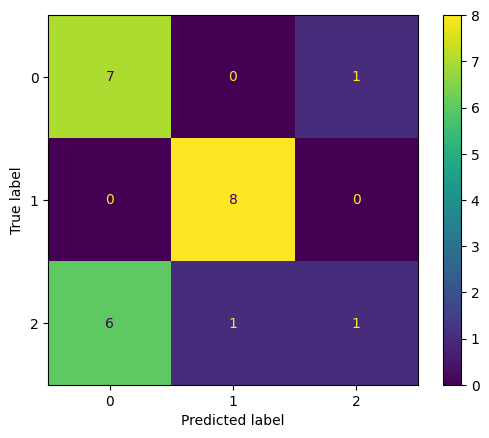

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf_lda, train_data[test_index], train_lbls[test_index])

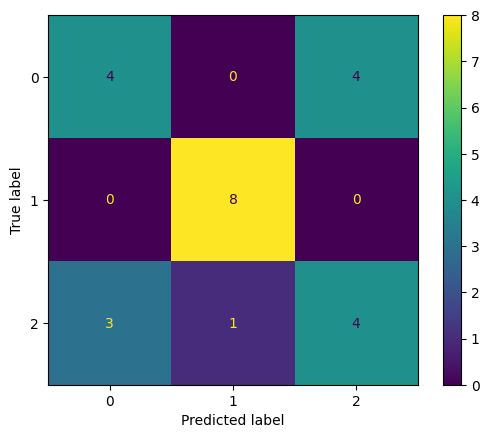

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf_svm, train_data[test_index], train_lbls[test_index])

In [ ]:
cross_score = clf_lda.score(train_data2, train_lbls2)
cross_score2 = clf_svm.score(train_data2, train_lbls2)

In [ ]:
# Test using moving window dataset
print(cross_score)
print(cross_score2)

0.6403508771929824
0.7132675438596491


#### Moving-window

In [ ]:
lda2 = LinearDiscriminantAnalysis()
svc2 = SVC(kernel='linear', gamma='auto', probability=True)
csp2 = CSP(n_components=csp_comp, reg=None, log=False, norm_trace=False)
#scaler = Scaler(scalings='mean')

clf_lda2 = Pipeline([("CSP", csp2), ("LDA", lda2)])
clf_svm2 = Pipeline([("CSP", csp2), ("SVC", svc2)])

In [ ]:
cv2 = GroupKFold(n_splits=len(type_dd))

In [ ]:
scores_lda2 = cross_val_score(clf_lda2, train_data2, train_lbls2, cv=cv2, groups=groups2, n_jobs=None)
scores_svm2 = cross_val_score(clf_svm2, train_data2, train_lbls2, cv=cv2, groups=groups2, n_jobs=None)

In [ ]:
# Printing the results
class_balance2 = np.mean(train_lbls2 == train_lbls2[0])
class_balance2 = max(class_balance2, 1.0 - class_balance2)
print("LDA Classification accuracy: %f / Chance level: %f" % (np.mean(scores_lda2), class_balance))
print(scores_lda2)
print("SVM Classification accuracy: %f / Chance level: %f" % (np.mean(scores_svm2), class_balance))
print(scores_svm2)

LDA Classification accuracy: 0.542763 / Chance level: 0.666667
[0.49561404 0.57675439 0.65350877 0.44517544]
SVM Classification accuracy: 0.608004 / Chance level: 0.666667
[0.58114035 0.65350877 0.69517544 0.50219298]


In [ ]:
for train_index2, test_index2 in cv2.split(train_data2, train_lbls2, groups2):
    break

In [ ]:
clf_lda2.fit(train_data2[train_index2], train_lbls2[train_index2])
clf_svm2.fit(train_data2[train_index2], train_lbls2[train_index2])

Pipeline(steps=[('CSP',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': False,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})),
                ('SVC', SVC(gamma='auto', kernel='linear', probability=True))])

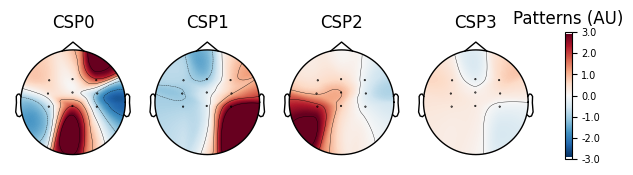

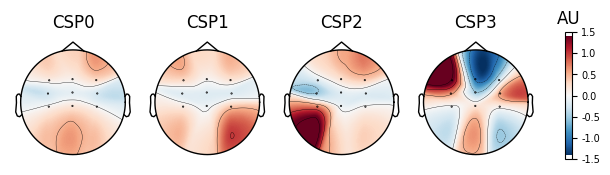

In [ ]:
csp2.fit_transform(train_data2, train_lbls2)

_ = csp2.plot_patterns(train_info2, ch_type="eeg", units="Patterns (AU)")
_ = csp2.plot_filters(train_info2, scalings=1e-6)

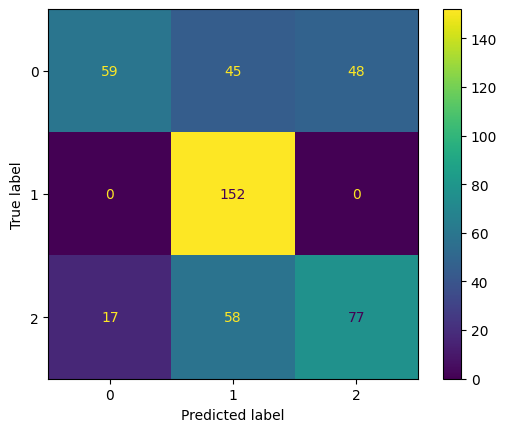

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf_lda2, train_data2[test_index2], train_lbls2[test_index2])

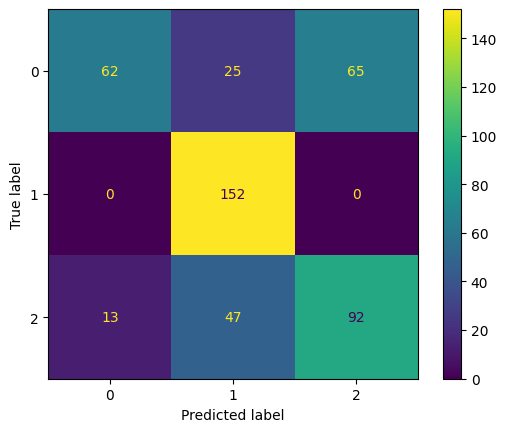

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf_svm2, train_data2[test_index2], train_lbls2[test_index2])

In [ ]:
cross_score = clf_lda2.score(train_data, train_lbls)
cross_score2 = clf_svm2.score(train_data, train_lbls)

In [ ]:
# Test using moving window dataset
print(cross_score)
print(cross_score2)

0.7083333333333334
0.71875


In [ ]:
dl_train_data2 = np.expand_dims(train_data2, axis=1).astype(np.float32)
dl_train_lbls2 = train_lbls2.astype(np.int64)

In [ ]:
net2 = NeuralNetClassifier(
    EEGNet,
    module__in_chn=dl_train_data2.shape[-2],
    module__n_cls=cls_n,
    module__input_ts=dl_train_data2.shape[-1],
    criterion = torch.nn.CrossEntropyLoss(),
    optimizer = torch.optim.AdamW,
    iterator_train__shuffle=True,
    batch_size = 16,
    callbacks=[
        EpochScoring(scoring='accuracy', name='train_acc', on_train=True),
        Checkpoint(monitor='valid_loss_best'),  # save based on validation loss
        #EarlyStopping(patience=50, monitor='valid_loss')
    ],
    max_epochs=200,
    lr=learn_rate,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [ ]:
scores2 = cross_val_score(net2, dl_train_data2, dl_train_lbls2, cv=cv2, groups=groups2, n_jobs=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.3446        1.1021       0.3321        1.0989     +  2.1615
      2       0.3446        1.1059       0.3321        1.1020        2.2242
      3       0.3711        1.0974       0.4051        1.0893     +  2.1208
      4       0.3601        1.0971       0.3139        1.0956        2.0822
      5       0.3995        1.0825       0.3212        1.0900        2.0673
      6       0.3766        1.0817       0.2956        1.0869     +  2.1422
      7       0.3885        1.0770       0.3175        1.0743     +  2.1714
      8       0.3684        1.0657       0.3358        1.0773        2.1942
      9       0.4104        1.0572       0.3431        1.0720     +  2.0896
     10       0.4049        1.0452       0.4672        1.0437     +  2.2212
     11       0.4378        1.0307       0.3321        1.0553        2.0769
     12     

In [ ]:
print("Cross-validated accuracy scores:", scores2)
print("Mean accuracy:", np.mean(scores2))

Cross-validated accuracy scores: [0.67982456 0.77412281 0.75219298 0.62719298]
Mean accuracy: 0.7083333333333334


In [ ]:
net2.fit(dl_train_data2[train_index2], dl_train_lbls2[train_index2])

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.3227        1.1261       0.3358        1.0987     +  2.0731
      2       0.3291        1.1102       0.3504        1.1000        2.2262
      3       0.3455        1.1025       0.3066        1.1073        2.0646
      4       0.3464        1.1118       0.3577        1.0908     +  2.0045
      5       0.3629        1.1016       0.3467        1.0928        1.9995
      6       0.3665        1.0934       0.3175        1.1052        2.0742
      7       0.3601        1.0922       0.3212        1.0886     +  2.0342
      8       0.3903        1.0719       0.3832        1.0710     +  2.2156
      9       0.3967        1.0665       0.4818        1.0526     +  2.1747
     10       0.4132        1.0551       0.4453        1.0470     +  2.1933
     11       0.4223        1.0445       0.3723        1.0546        2.1250
     12     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=EEGNet(
    (conv1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (0): Conv2d(8, 16, kernel_size=(9, 1), stride=(1, 1), groups=8, bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
      (4): Dropout(p=0.5, inplace=False)
    )
    (conv3): Sequential(
      (0): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=16, bias=False)
      (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ELU(alpha=1.0)
      (4): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), 

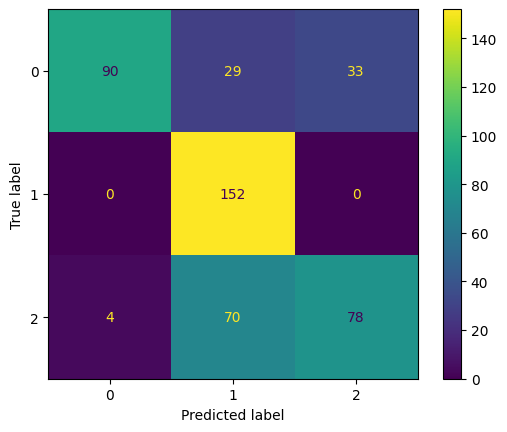

In [ ]:
ConfusionMatrixDisplay.from_estimator(net2, dl_train_data2[test_index2], dl_train_lbls2[test_index2])

### Test

#### Event

In [ ]:
test_trial, test_trial_lbl, _ = make_dataset([straight[-1], left[-1], right[-1]], [0,1,2], filter=bp_range, pick=chn_select, sample_rate=sample_rate)
test_subs, test_subs_lbl, _ = make_sub_dataset([straight[-1], left[-1], right[-1]], [0,1,2], filter=bp_range, pick=chn_select, sample_rate=sample_rate)

Trial trained classifiers

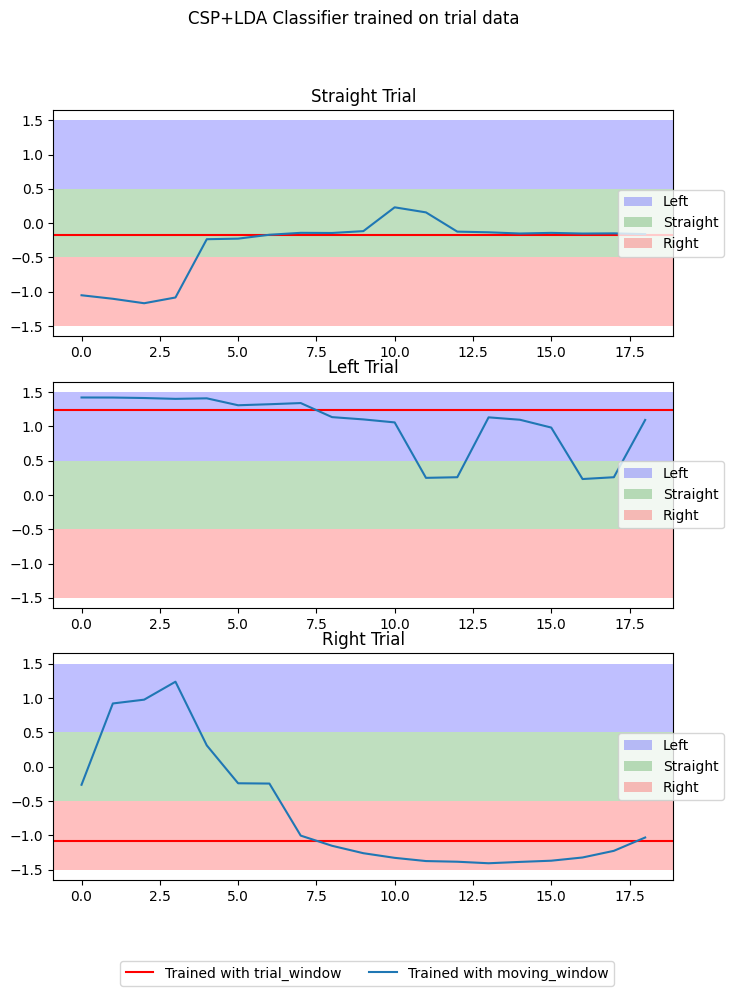

In [ ]:
trial_res = clf_lda.predict_proba(test_trial)
subs_res = clf_lda.predict_proba(test_subs)
_ = plot_predict(trial_res, subs_res, ['Straight Trial', 'Left Trial', 'Right Trial'], title='CSP+LDA Classifier trained on trial data')

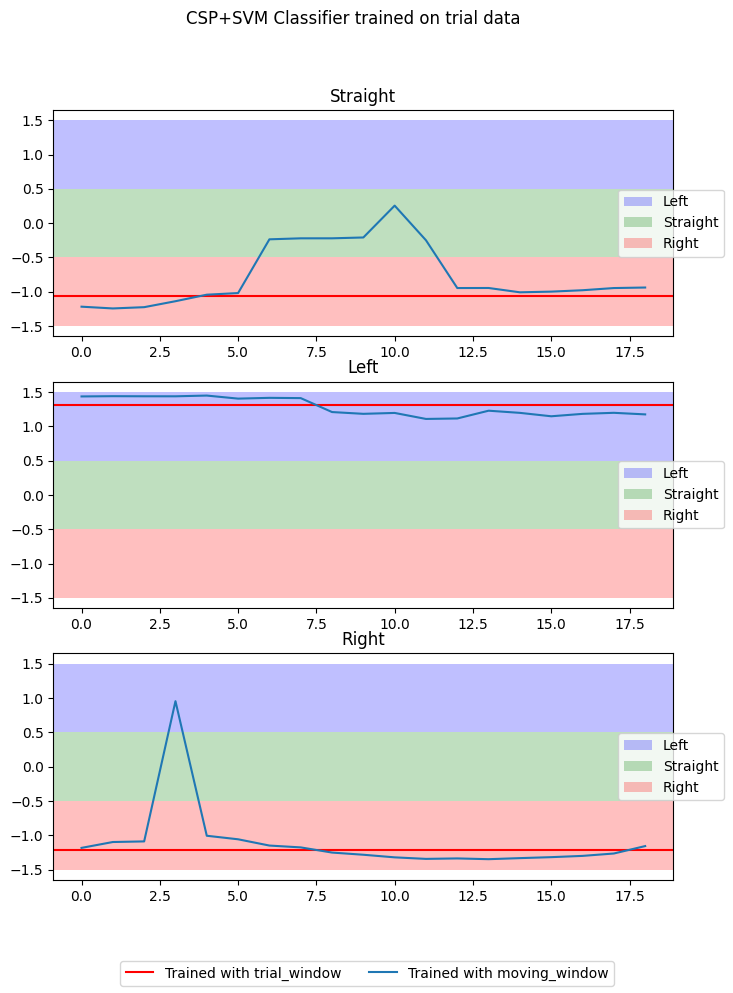

In [ ]:
trial_res = clf_svm.predict_proba(test_trial)
subs_res = clf_svm.predict_proba(test_subs)
_ = plot_predict(trial_res, subs_res, ['Straight', 'Left', 'Right'], title='CSP+SVM Classifier trained on trial data' )

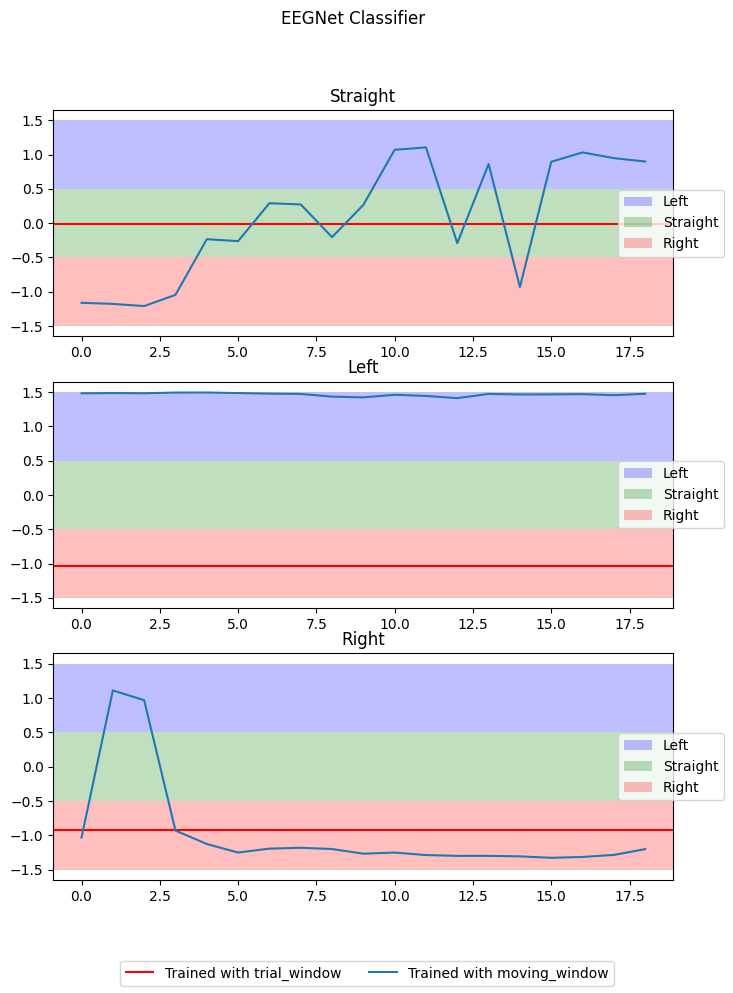

In [ ]:
trial_res = net.predict_proba(np.expand_dims(test_trial, axis=1).astype(np.float32))
subs_res = net2.predict_proba(np.expand_dims(test_subs, axis=1).astype(np.float32))
_ = plot_predict(trial_res, subs_res, ['Straight', 'Left', 'Right'], title='EEGNet Classifier')

Moving window trained classifiers

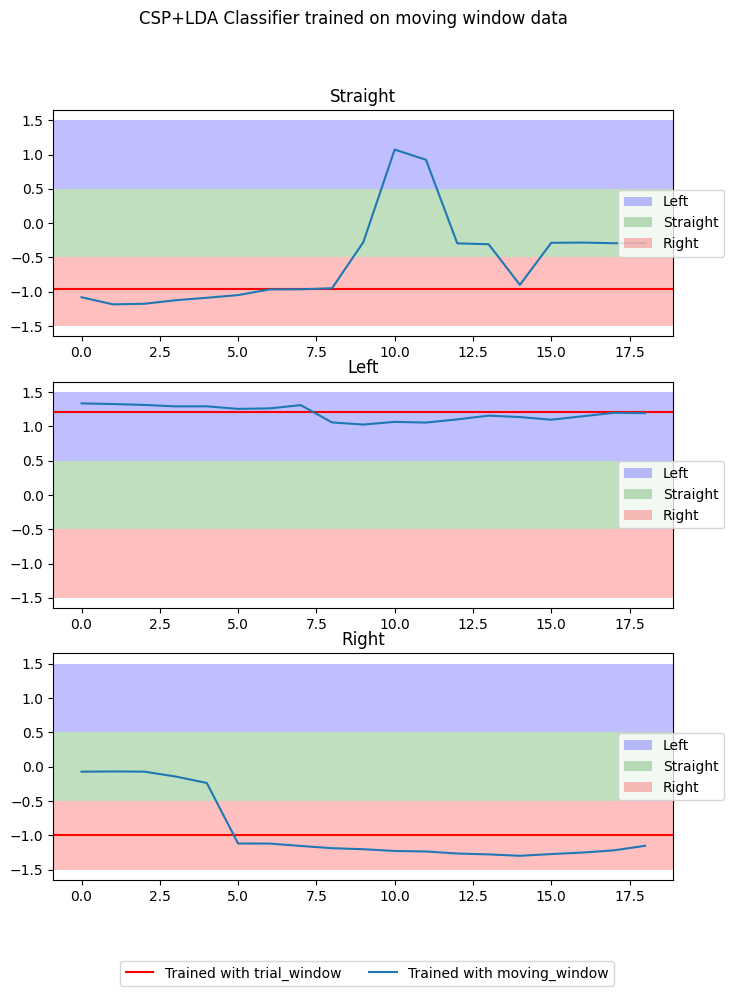

In [ ]:
trial_res2 = clf_lda2.predict_proba(test_trial)
subs_res2 = clf_lda2.predict_proba(test_subs)
_ = plot_predict(trial_res2, subs_res2, ['Straight', 'Left', 'Right'], title='CSP+LDA Classifier trained on moving window data')

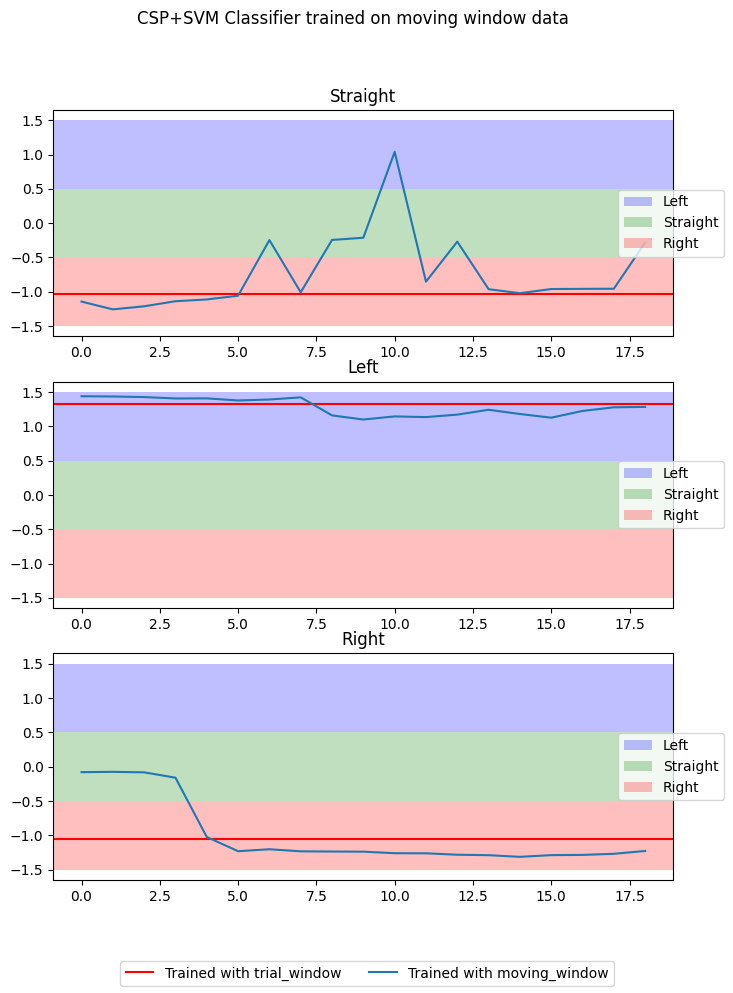

In [ ]:
trial_res2 = clf_svm2.predict_proba(test_trial)
subs_res2 = clf_svm2.predict_proba(test_subs)
_ = plot_predict(trial_res2, subs_res2, ['Straight', 'Left', 'Right'], title='CSP+SVM Classifier trained on moving window data')

#### Lap

In [ ]:
test_lap = sbj_sub_lap_list[-1].copy()
test_ep = test_lap.filter(l_freq=bp_range[0], h_freq=bp_range[1])
if sample_rate is not None:
  test_ep.resample(sample_rate, npad='auto')
test_array = test_ep.get_data(picks=chn_select, copy=True)

In [ ]:
evt, evt_dict = mne.events_from_annotations(sbj_laps[-1])
evt_line = ((evt[:, 0] - evt[0, 0])/sbj_laps[-1].info['sfreq'])/sbj_laps[-1].times[-1]*len(test_lap)

In [ ]:
lap_predict_trial = clf_lda.predict_proba(test_array)
lap_predict_mw = clf_lda2.predict_proba(test_array)

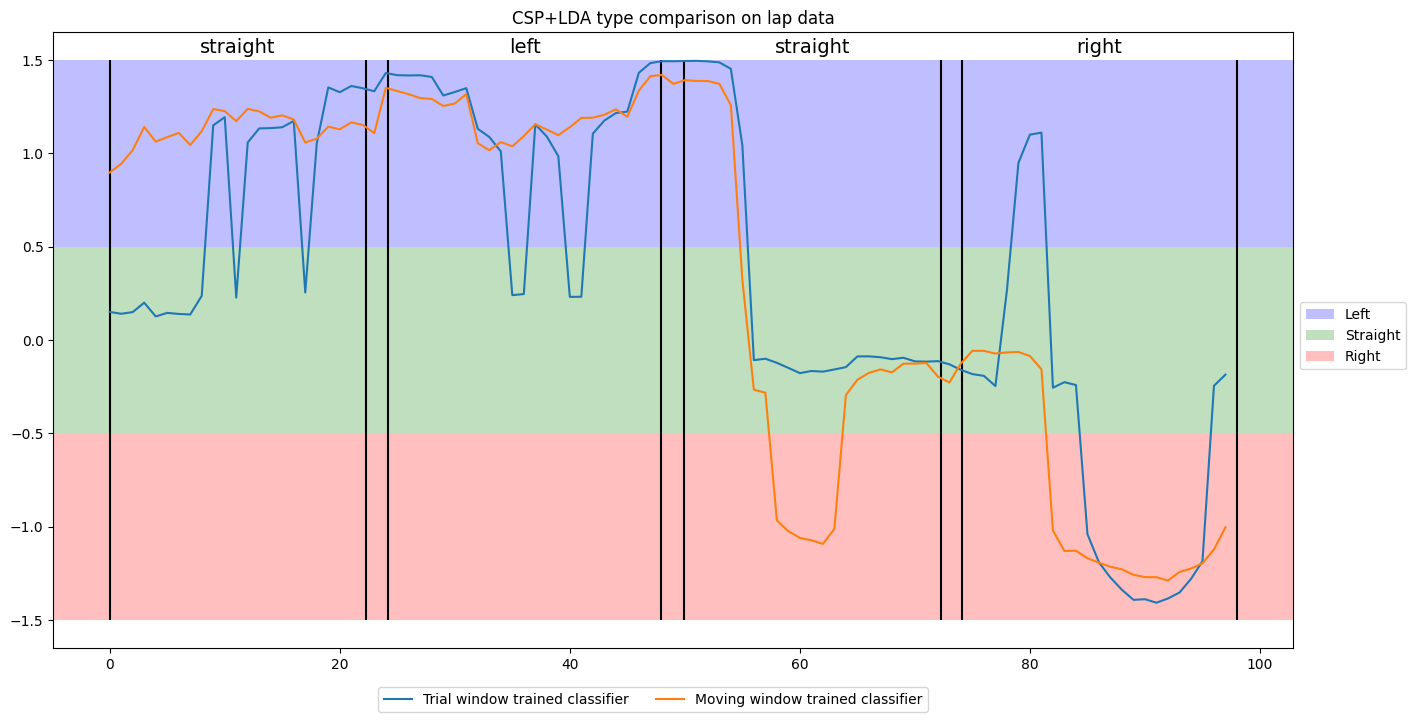

In [ ]:
_ = plot_predict(lap_predict_trial, lap_predict_mw, ['Straight', 'Left', 'Right'], plt_type='lap', ev_line=evt_line, fig_size=(16, 8), title='CSP+LDA type comparison on lap data')

In [ ]:
lap_predict_trial = clf_svm.predict_proba(test_array)
lap_predict_mw = clf_svm2.predict_proba(test_array)

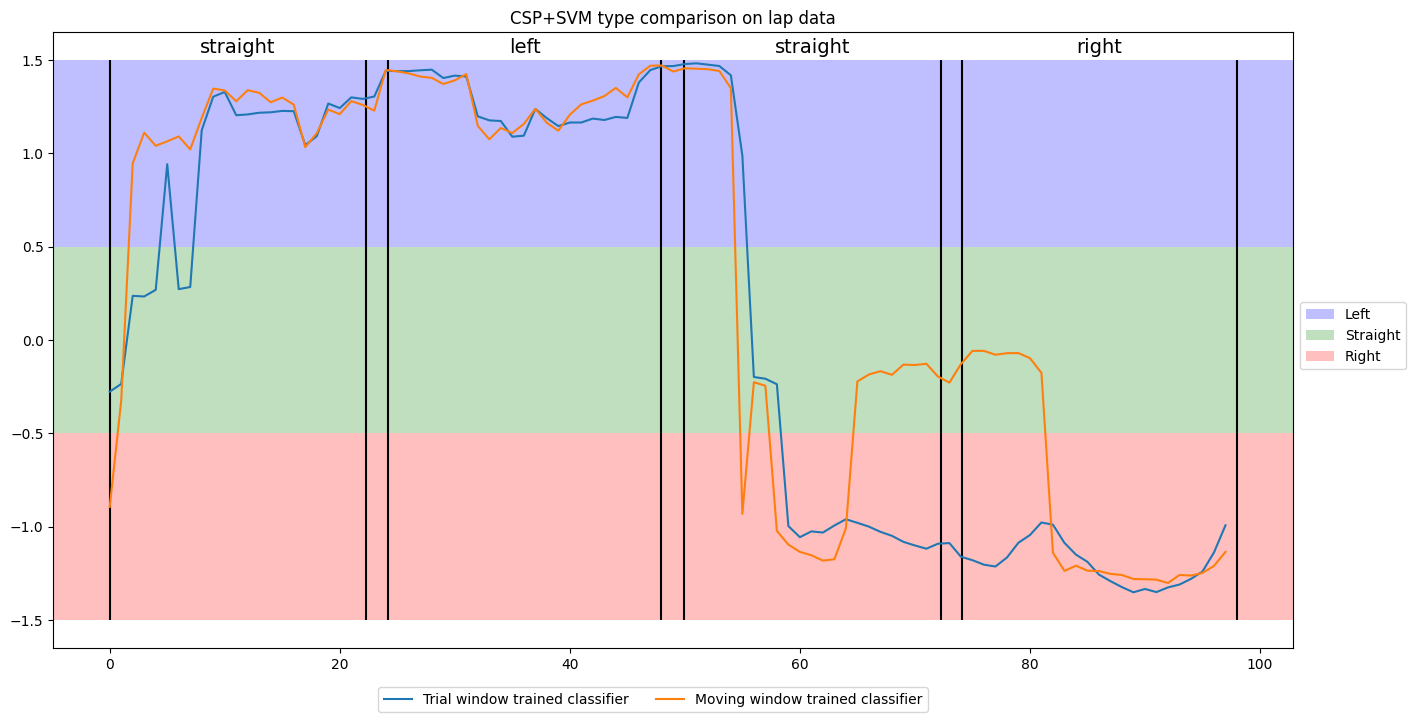

In [ ]:
_ = plot_predict(lap_predict_trial, lap_predict_mw, ['Straight', 'Left', 'Right'], plt_type='lap', ev_line=evt_line, fig_size=(16, 8), title='CSP+SVM type comparison on lap data')

In [ ]:
lap_test_ep = [straight[-2],left[-1],straight[-1],right[-1]]
lap_test_array = [x.filter(l_freq=bp_range[0], h_freq=bp_range[1]) for x in lap_test_ep]
if sample_rate is not None:
  lap_test_array = [x.resample(sample_rate, npad='auto') for x in lap_test_array]
lap_test_array = [x.get_data(picks=chn_select, copy=True) for x in lap_test_array]
lap_test_array =  np.concatenate(lap_test_array, axis=0)

In [ ]:
lap_predict_trial = net.predict_proba(np.expand_dims(lap_test_array, axis=1).astype(np.float32))

In [ ]:
lap_predict_mw = net2.predict_proba(np.expand_dims(test_array, axis=1).astype(np.float32))

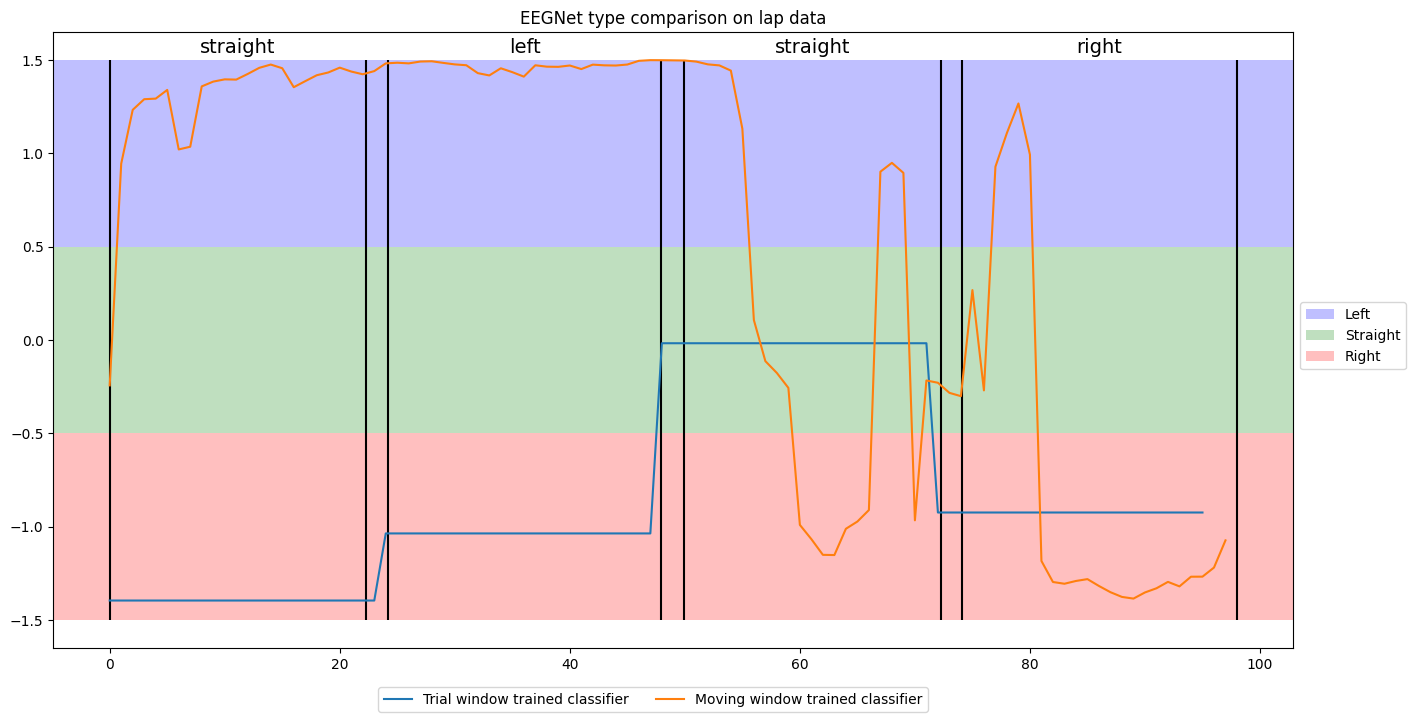

In [ ]:
_ = plot_predict(lap_predict_trial, lap_predict_mw, ['Straight', 'Left', 'Right'], plt_type='lap', ev_line=evt_line, fig_size=(16, 8), title='EEGNet type comparison on lap data')

## Clear

In [ ]:
gc.collect()

47262

## Type 2 Data

In [ ]:
type_dd = type_2 # @param ["type_1", "type_2"] {type:"raw"}
print(type_dd)

['record-[2024.01.31]_S1_2.gdf', 'record-[2024.01.31]_S3_2.gdf', 'record-[2024.01.31]_S5_2.gdf', 'record-[2024.01.31]_S7_2.gdf']


In [ ]:
all_raw = load_set(type_dd)

File path: /content/drive/MyDrive/Th/EEG Recording/Subject 2/record-[2024.01.31]_S1_2.gdf
File path: /content/drive/MyDrive/Th/EEG Recording/Subject 2/record-[2024.01.31]_S3_2.gdf
File path: /content/drive/MyDrive/Th/EEG Recording/Subject 2/record-[2024.01.31]_S5_2.gdf
File path: /content/drive/MyDrive/Th/EEG Recording/Subject 2/record-[2024.01.31]_S7_2.gdf


In [ ]:
sbj = SubjectEpochs(all_raw)
sbj.base_img_split()

Average duration of this session trials :  6.27
Average duration of this session trials :  6.28
Average duration of this session trials :  6.27
Average duration of this session trials :  6.27


In [ ]:
base_list ,base_epochs = sbj.create_sub_epoch(sbj.baseline)

Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated


### Base PSD

### Base MAV

In [ ]:
base_mav = np.abs(base_epochs.get_data(copy=True)).mean(axis=2)

## Laps

In [ ]:
sbj_laps, sbj_lap_epochs = sbj.segment_laps()

Average duration of this session trials :  6.27
Average duration of this session trials :  6.28
Average duration of this session trials :  6.27
Average duration of this session trials :  6.27


<ipython-input-25-991b971acef8>:93: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  lap_eps = mne.concatenate_epochs(lap_list)


### PSD

In [ ]:
sbj_sub_lap_list, sbj_sub_laps = sbj.moving_epoch(sbj_laps)

Not setting metadata
147 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
147 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
147 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
147 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
147 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
147 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
147 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
147 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
147 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
147 matching eve

In [ ]:
evs, ev_dict = mne.events_from_annotations(sbj_laps[0])

### MAV

In [ ]:
sbj_mav = np.abs(sbj_lap_epochs.get_data(copy=True)).mean(axis=2)

## Event

In [ ]:
left = sbj.event_epoch('left', tmax=6)
right = sbj.event_epoch('right', tmax=6)
straight = sbj.event_epoch('straight', tmax=6)

<ipython-input-25-991b971acef8>:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  event_epochs = mne.concatenate_epochs(event_list)
<ipython-input-25-991b971acef8>:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  event_epochs = mne.concatenate_epochs(event_list)
<ipython-input-25-991b971acef8>:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  event_epochs = mne.concatenate_epochs(event_list)


### Train

#### Dataset

In [ ]:
train_data, train_lbls, train_info = make_dataset([straight, left, right], [0,1,2], balance=True, filter=bp_range, pick=chn_select, sample_rate=sample_rate)

In [ ]:
train_data2, train_lbls2, train_info2 = make_sub_dataset([straight, left, right], [0,1,2], balance=True, filter=bp_range, pick=chn_select, sample_rate=sample_rate)

In [ ]:
groups = np.concatenate([[i] * int((train_data.shape[0]/3)/len(type_dd)) for i in range(0, len(type_dd))]*3)
groups2 = np.concatenate([[i] * int((train_data2.shape[0]/3)/len(type_dd)) for i in range(0, len(type_dd))]*3)

#### Classifier

In [ ]:
lda = LinearDiscriminantAnalysis()
svc = SVC(kernel='linear', gamma='auto', probability=True)
csp = CSP(n_components=csp_comp, reg=None, log=False, norm_trace=False)
#scaler = Scaler(scalings='mean')

clf_lda = Pipeline([("CSP", csp), ("LDA", lda)])
clf_svm = Pipeline([("CSP", csp), ("SVC", svc)])

In [ ]:
cv = GroupKFold(n_splits=len(type_dd))

In [ ]:
scores_lda = cross_val_score(clf_lda, train_data, train_lbls, cv=cv, groups=groups, n_jobs=None)

In [ ]:
scores_svc = cross_val_score(clf_svm, train_data, train_lbls, cv=cv, groups=groups, n_jobs=None)

In [ ]:
# Printing the results
class_balance = np.mean(train_lbls == train_lbls[0])
class_balance = max(class_balance, 1.0 - class_balance)
print("LDA Classification accuracy: %f / Chance level: %f" % (np.mean(scores_lda), class_balance))
print(scores_lda)
print("SVM Classification accuracy: %f / Chance level: %f" % (np.mean(scores_svc), class_balance))
print(scores_svc)

LDA Classification accuracy: 0.781250 / Chance level: 0.666667
[0.75       0.79166667 0.875      0.70833333]
SVM Classification accuracy: 0.781250 / Chance level: 0.666667
[0.83333333 0.79166667 0.83333333 0.66666667]


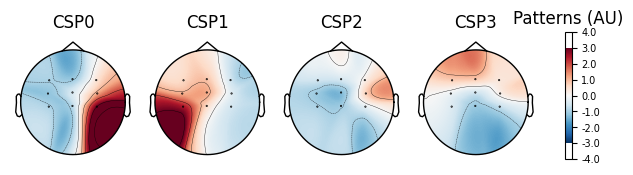

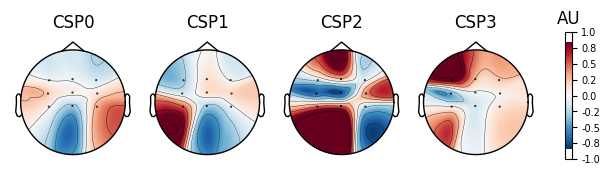

In [ ]:
csp.fit_transform(train_data, train_lbls)

_ = csp.plot_patterns(train_info, ch_type="eeg", units="Patterns (AU)")
_ = csp.plot_filters(train_info, scalings=1e-6)

In [ ]:
for train_index, test_index in cv.split(train_data, train_lbls, groups):
    break

In [ ]:
clf_lda.fit(train_data[train_index], train_lbls[train_index])
clf_svm.fit(train_data[train_index], train_lbls[train_index])

Pipeline(steps=[('CSP',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': False,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})),
                ('SVC', SVC(gamma='auto', kernel='linear', probability=True))])

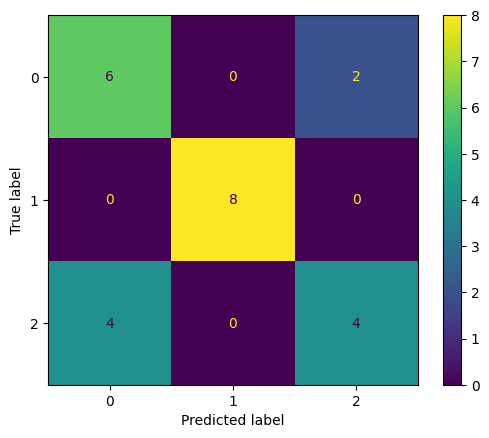

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf_lda, train_data[test_index], train_lbls[test_index])

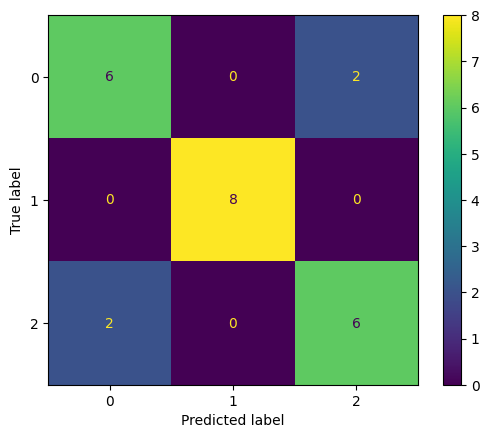

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf_svm, train_data[test_index], train_lbls[test_index])

In [ ]:
cross_score = clf_lda.score(train_data2, train_lbls2)
cross_score2 = clf_svm.score(train_data2, train_lbls2)

In [ ]:
# Test using moving window dataset
print(cross_score)
print(cross_score2)

0.7198464912280702
0.7357456140350878


In [ ]:
dl_train_data = np.expand_dims(train_data, axis=1).astype(np.float32)
dl_train_lbls = train_lbls.astype(np.int64)

In [ ]:
print(dl_train_data.shape)
print(dl_train_lbls.shape)

(96, 1, 9, 3251)
(96,)


In [ ]:
net = NeuralNetClassifier(
    EEGNet,
    module__in_chn=dl_train_data.shape[-2],
    module__n_cls=cls_n,
    module__input_ts=dl_train_data.shape[-1],
    criterion = torch.nn.CrossEntropyLoss(),
    optimizer = torch.optim.AdamW,
    iterator_train__shuffle=True,
    batch_size = 16,
    callbacks=[
        EpochScoring(scoring='accuracy', name='train_acc', on_train=True),
        Checkpoint(monitor='valid_loss_best'),  # save based on validation loss
        #EarlyStopping(patience=50, monitor='valid_loss')
    ],
    max_epochs=200,
    lr=learn_rate,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [ ]:
scores = cross_val_score(net, dl_train_data, dl_train_lbls, cv=cv, groups=groups, n_jobs=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.3509        1.1147       0.3333        1.0988     +  0.3585
      2       0.3684        1.1042       0.3333        1.0988     +  0.3496
      3       0.4386        1.0839       0.3333        1.0988     +  0.3511
      4       0.3158        1.1120       0.3333        1.0988     +  0.3466
      5       0.3860        1.0796       0.3333        1.0988     +  0.3455
      6       0.2982        1.1113       0.3333        1.0988     +  0.3468
      7       0.2632        1.1181       0.3333        1.0988     +  0.3344
      8       0.3158        1.1096       0.3333        1.0988     +  0.3642
      9       0.4211        1.0672       0.3333        1.0987     +  0.3503
     10       0.4035        1.0794       0.3333        1.0987     +  0.3632
     11       0.4386        1.0583       0.3333        1.0987     +  0.3610
     12     

In [ ]:
print("Cross-validated accuracy scores:", scores)
print("Mean accuracy:", np.mean(scores))

Cross-validated accuracy scores: [0.29166667 0.25       0.41666667 0.25      ]
Mean accuracy: 0.30208333333333337


In [ ]:
net.fit(dl_train_data[train_index], dl_train_lbls[train_index])

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.3684        1.1094       0.3333        1.0986     +  0.3336
      2       0.3333        1.0791       0.3333        1.0986        0.3423
      3       0.4386        1.0853       0.3333        1.0986     +  0.3458
      4       0.3333        1.1214       0.3333        1.0986        0.3372
      5       0.3333        1.0960       0.3333        1.0986     +  0.3371
      6       0.4386        1.0685       0.3333        1.0986        0.3424
      7       0.3333        1.0592       0.3333        1.0986     +  0.3378
      8       0.4561        1.0374       0.3333        1.0986        0.3314
      9       0.4386        1.0352       0.3333        1.0986        0.3373
     10       0.4386        1.0537       0.3333        1.0986        0.3377
     11       0.4211        1.0712       0.3333        1.0986        0.3424
     12     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=EEGNet(
    (conv1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (0): Conv2d(8, 16, kernel_size=(9, 1), stride=(1, 1), groups=8, bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
      (4): Dropout(p=0.5, inplace=False)
    )
    (conv3): Sequential(
      (0): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=16, bias=False)
      (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ELU(alpha=1.0)
      (4): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), 

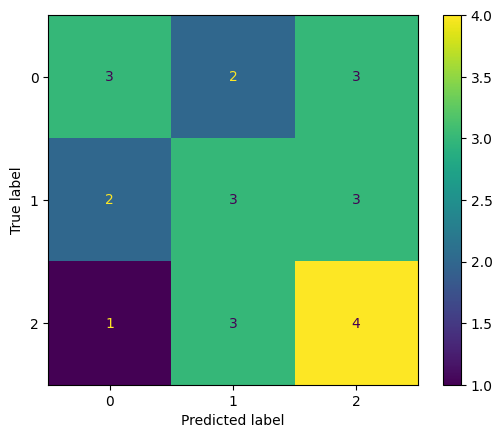

In [ ]:
ConfusionMatrixDisplay.from_estimator(net, dl_train_data[test_index], dl_train_lbls[test_index])

#### Moving-window

In [ ]:
lda2 = LinearDiscriminantAnalysis()
svc2 = SVC(kernel='linear', gamma='auto', probability=True)
csp2 = CSP(n_components=csp_comp, reg=None, log=False, norm_trace=False)
#scaler = Scaler(scalings='mean')

clf_lda2 = Pipeline([("CSP", csp2), ("LDA", lda2)])
clf_svm2 = Pipeline([("CSP", csp2), ("SVC", svc2)])

In [ ]:
cv2 = GroupKFold(n_splits=len(type_dd))

In [ ]:
scores_lda2 = cross_val_score(clf_lda2, train_data2, train_lbls2, cv=cv2, groups=groups2, n_jobs=None)
scores_svm2 = cross_val_score(clf_svm2, train_data2, train_lbls2, cv=cv2, groups=groups2, n_jobs=None)

In [ ]:
# Printing the results
class_balance2 = np.mean(train_lbls2 == train_lbls2[0])
class_balance2 = max(class_balance2, 1.0 - class_balance2)
print("LDA Classification accuracy: %f / Chance level: %f" % (np.mean(scores_lda2), class_balance))
print(scores_lda2)
print("SVM Classification accuracy: %f / Chance level: %f" % (np.mean(scores_svm2), class_balance))
print(scores_svm2)

LDA Classification accuracy: 0.676535 / Chance level: 0.666667
[0.75219298 0.6754386  0.65131579 0.62719298]
SVM Classification accuracy: 0.685307 / Chance level: 0.666667
[0.74122807 0.6995614  0.69078947 0.60964912]


In [ ]:
for train_index2, test_index2 in cv2.split(train_data2, train_lbls2, groups2):
    break

In [ ]:
clf_lda2.fit(train_data2[train_index2], train_lbls2[train_index2])
clf_svm2.fit(train_data2[train_index2], train_lbls2[train_index2])

Pipeline(steps=[('CSP',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': False,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})),
                ('SVC', SVC(gamma='auto', kernel='linear', probability=True))])

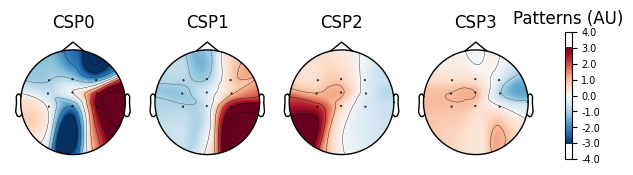

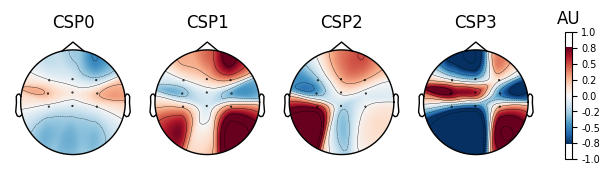

In [ ]:
csp2.fit_transform(train_data2, train_lbls2)

_ = csp2.plot_patterns(train_info2, ch_type="eeg", units="Patterns (AU)")
_ = csp2.plot_filters(train_info2, scalings=1e-6)

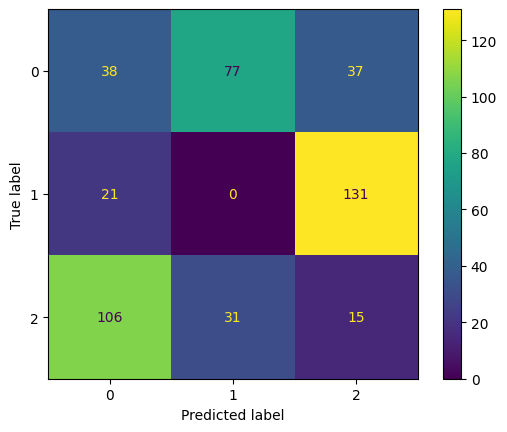

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf_lda2, train_data2[test_index2], train_lbls2[test_index2])

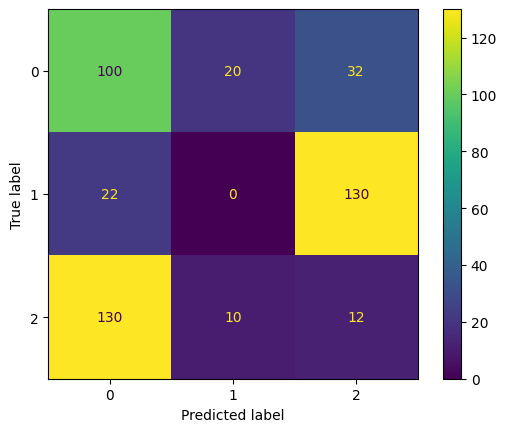

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf_svm2, train_data2[test_index2], train_lbls2[test_index2])

In [ ]:
cross_score = clf_lda2.score(train_data, train_lbls)
cross_score2 = clf_svm2.score(train_data, train_lbls)

In [ ]:
# Test using moving window dataset
print(cross_score)
print(cross_score2)

0.15625
0.2916666666666667


In [ ]:
dl_train_data2 = np.expand_dims(train_data2, axis=1).astype(np.float32)
dl_train_lbls2 = train_lbls2.astype(np.int64)

In [ ]:
net2 = NeuralNetClassifier(
    EEGNet,
    module__in_chn=dl_train_data2.shape[-2],
    module__n_cls=cls_n,
    module__input_ts=dl_train_data2.shape[-1],
    criterion = torch.nn.CrossEntropyLoss(),
    optimizer = torch.optim.AdamW,
    iterator_train__shuffle=True,
    batch_size = 16,
    callbacks=[
        EpochScoring(scoring='accuracy', name='train_acc', on_train=True),
        Checkpoint(monitor='valid_loss_best'),  # save based on validation loss
        #EarlyStopping(patience=50, monitor='valid_loss')
    ],
    max_epochs=200,
    lr=learn_rate,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [ ]:
scores2 = cross_val_score(net2, dl_train_data2, dl_train_lbls2, cv=cv2, groups=groups2, n_jobs=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.3638        1.1059       0.2883        1.0987     +  1.2785
      2       0.3537        1.1016       0.3066        1.1059        1.2327
      3       0.3510        1.1059       0.2920        1.1059        1.2429
      4       0.3473        1.0990       0.3321        1.0976     +  1.3167
      5       0.3419        1.1072       0.3394        1.0997        1.1613
      6       0.3464        1.1005       0.3102        1.0964     +  1.1717
      7       0.3766        1.0925       0.3139        1.0967        1.2998
      8       0.3848        1.0876       0.3358        1.1310        1.1639
      9       0.3903        1.0846       0.3248        1.0952     +  1.2208
     10       0.3885        1.0742       0.3212        1.1103        1.2793
     11       0.4059        1.0740       0.4197        1.0738     +  1.2804
     12     

In [ ]:
print("Cross-validated accuracy scores:", scores2)
print("Mean accuracy:", np.mean(scores2))

In [ ]:
net2.fit(dl_train_data2[train_index2], dl_train_lbls2[train_index2])

In [ ]:
ConfusionMatrixDisplay.from_estimator(net2, dl_train_data2[test_index2], dl_train_lbls2[test_index2])

### Test

#### Event

In [ ]:
test_trial, test_trial_lbl, _ = make_dataset([straight[-1], left[-1], right[-1]], [0,1,2], filter=bp_range, pick=chn_select, sample_rate=sample_rate)
test_subs, test_subs_lbl, _ = make_sub_dataset([straight[-1], left[-1], right[-1]], [0,1,2], filter=bp_range, pick=chn_select, sample_rate=sample_rate)

Trial trained classifiers

In [ ]:
trial_res = clf_lda.predict_proba(test_trial)
subs_res = clf_lda.predict_proba(test_subs)
_ = plot_predict(trial_res, subs_res, ['Straight Trial', 'Left Trial', 'Right Trial'], title='CSP+LDA Classifier trained on trial data')

In [ ]:
trial_res = clf_svm.predict_proba(test_trial)
subs_res = clf_svm.predict_proba(test_subs)
_ = plot_predict(trial_res, subs_res, ['Straight', 'Left', 'Right'], title='CSP+SVM Classifier trained on trial data' )

In [ ]:
trial_res = net.predict_proba(np.expand_dims(test_trial, axis=1).astype(np.float32))
subs_res = net2.predict_proba(np.expand_dims(test_subs, axis=1).astype(np.float32))
_ = plot_predict(trial_res, subs_res, ['Straight', 'Left', 'Right'], title='EEGNet Classifier')

Moving window trained classifiers

In [ ]:
trial_res2 = clf_lda2.predict_proba(test_trial)
subs_res2 = clf_lda2.predict_proba(test_subs)
_ = plot_predict(trial_res2, subs_res2, ['Straight', 'Left', 'Right'], title='CSP+LDA Classifier trained on moving window data')

In [ ]:
trial_res2 = clf_svm2.predict_proba(test_trial)
subs_res2 = clf_svm2.predict_proba(test_subs)
_ = plot_predict(trial_res2, subs_res2, ['Straight', 'Left', 'Right'], title='CSP+SVM Classifier trained on moving window data')

#### Lap

In [ ]:
test_lap = sbj_sub_lap_list[-1].copy()
test_ep = test_lap.filter(l_freq=bp_range[0], h_freq=bp_range[1])
if sample_rate is not None:
  test_ep.resample(sample_rate, npad='auto')
test_array = test_ep.get_data(picks=chn_select, copy=True)

In [ ]:
evt, evt_dict = mne.events_from_annotations(sbj_laps[-1])
evt_line = ((evt[:, 0] - evt[0, 0])/sbj_laps[-1].info['sfreq'])/sbj_laps[-1].times[-1]*len(test_lap)

In [ ]:
lap_predict_trial = clf_lda.predict_proba(test_array)
lap_predict_mw = clf_lda2.predict_proba(test_array)

In [ ]:
_ = plot_predict(lap_predict_trial, lap_predict_mw, ['Straight', 'Left', 'Right'], plt_type='lap', ev_line=evt_line, fig_size=(16, 8), title='CSP+LDA type comparison on lap data')

In [ ]:
lap_predict_trial = clf_svm.predict_proba(test_array)
lap_predict_mw = clf_svm2.predict_proba(test_array)

In [ ]:
_ = plot_predict(lap_predict_trial, lap_predict_mw, ['Straight', 'Left', 'Right'], plt_type='lap', ev_line=evt_line, fig_size=(16, 8), title='CSP+SVM type comparison on lap data')

In [ ]:
lap_test_ep = [straight[-2],left[-1],straight[-1],right[-1]]
lap_test_array = [x.filter(l_freq=bp_range[0], h_freq=bp_range[1]) for x in lap_test_ep]
if sample_rate is not None:
  lap_test_array = [x.resample(sample_rate, npad='auto') for x in lap_test_array]
lap_test_array = [x.get_data(picks=chn_select, copy=True) for x in lap_test_array]
lap_test_array =  np.concatenate(lap_test_array, axis=0)

In [ ]:
lap_predict_trial = net.predict_proba(np.expand_dims(lap_test_array, axis=1).astype(np.float32))

In [ ]:
lap_predict_mw = net2.predict_proba(np.expand_dims(test_array, axis=1).astype(np.float32))

In [ ]:
_ = plot_predict(lap_predict_trial, lap_predict_mw, ['Straight', 'Left', 'Right'], plt_type='lap', ev_line=evt_line, fig_size=(16, 8), title='EEGNet type comparison on lap data')